In [38]:
import os
from dotenv import load_dotenv
load_dotenv()

os.environ['LANGSMITH_TRACING'] = "true"

In [39]:
from langchain.chat_models import init_chat_model

model = init_chat_model("llama-3.3-70b-versatile", model_provider="groq")

In [40]:
from langchain_huggingface import HuggingFaceEmbeddings

embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2")

In [41]:
from langchain_core.vectorstores import InMemoryVectorStore

vector_store = InMemoryVectorStore(embeddings)

In [42]:
import bs4 
from langchain_community.document_loaders import WebBaseLoader

loader = WebBaseLoader(
    web_paths=["https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/"],
    bs_kwargs=dict(
        parse_only = bs4.SoupStrainer(class_=("post-title", "post-header", "post-content"))
    )
)
docs = loader.load()

assert len(docs) == 1

print(f"Total characters: {len(docs[0].page_content)}")



Total characters: 29295


In [ ]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,
    chunk_overlap=200,
    add_start_index=True,
)
all_splits = text_splitter.split_documents(docs)



print(f"all_splits metadata {all_splits[0].metadata}")

print(f"all_splits {all_splits}")

print(f"Split blog post into {len(all_splits)} sub-documents")

all_splits metadata {'source': 'https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/', 'start_index': 8, 'section': 'beginning'}
all_splits [Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/', 'start_index': 8, 'section': 'beginning'}, page_content='Prompt Engineering\n    \nDate: March 15, 2023  |  Estimated Reading Time: 21 min  |  Author: Lilian Weng'), Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/', 'start_index': 114, 'section': 'beginning'}, page_content='Prompt Engineering, also known as In-Context Prompting, refers to methods for how to communicate with LLM to steer its behavior for desired outcomes without updating the model weights. It is an empirical science and the effect of prompt engineering methods can vary a lot among models, thus requiring heavy experimentation and heuristics.\nThis post only focuses on prompt engineering for autoregressive language models, so n

In [44]:
document_ids = vector_store.add_documents(documents=all_splits) 

print(document_ids[:3])

['726b92bd-d868-455e-8847-955b3fec5ee3', '2d5b9101-2fc2-4ee5-b46f-12e5f70e3435', '706e6433-aaa0-4fb9-a042-8d06a6013435']


In [54]:
from langchain import hub
from langchain_core.prompts import PromptTemplate

template = """Use the following pieces of context to answer the question at the end.
If you don't know the answer, just say that you don't have enough context, try to make up an answer mentioning this is not in the context you have and therefore should be taken with caution.
Use as many sentences as needed to explain yourself as clear as possible.
Always say "thanks for asking!" at the end of the answer. 
{context}

Question: {question}

Helpful Answer:"""

custom_rag_prompt = PromptTemplate.from_template(template)

# prompt = hub.pull("rlm/rag-prompt")

# example_messages = prompt.invoke(
#     { "context" :"(context goes here)", "question": "(question goes here)"}
# ).to_messages()

example_messages = custom_rag_prompt.invoke(
    { "context" :"(context goes here)", "question": "(question goes here)"}
).to_messages()

assert len(example_messages) == 1
print(example_messages[0].content)

Use the following pieces of context to answer the question at the end.
If you don't know the answer, just say that you don't have enough context, try to make up an answer mentioning this is not in the context you have and therefore should be taken with caution.
Use as many sentences as needed to explain yourself as clear as possible.
Always say "thanks for asking!" at the end of the answer. 
(context goes here)

Question: (question goes here)

Helpful Answer:


In [46]:
from langchain_core.documents import Document
from typing import Literal
from typing_extensions import List, TypedDict, Annotated

class Search(TypedDict):
    """Search Query."""

    query: Annotated[str, ..., "Search query ro run."]
    section: Annotated[
        Literal["beginning", "middle", "end"],
        ...,
        "Section to query."
        ]

class State(TypedDict):
    question: str
    query: Search
    context: List[Document]
    answer: str

In [55]:
def analyze_query(state:State):
    structured_llm = model.with_structured_output(Search)
    query = structured_llm.invoke(state["question"])
    return {"query": query}

def retrieve(state=State):
    query = state["query"]
    retrieved_docs = vector_store.similarity_search(
        query["query"],
        filter = lambda doc: doc.metadata.get("section") == query["section"]        
    )
    return { "context" : retrieved_docs}

def generate(state: State):
    docs_content ="\n\n".join(doc.page_content for doc in state["context"])
    messages = custom_rag_prompt.invoke({"question": state["question"], "context": docs_content})
    # messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = model.invoke(messages)
    return {"answer": response.content}


In [48]:
from langgraph.graph import START, StateGraph

graph_builder = StateGraph(State).add_sequence([analyze_query, retrieve,generate])
graph_builder.add_edge(START, "analyze_query")
graph = graph_builder.compile()


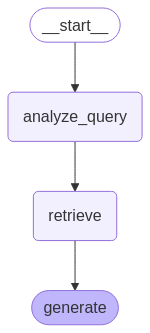

In [49]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [56]:
# result = graph.invoke({ "question" : " What is a reward function in reinforcement leaning"})


# print(f'Context: {result["context"]}\n\n')
# print(f'Answer: {result["answer"]}')

for step in graph.stream(
    {"question": "what  does the end of article says about Toolformer "}, stream_mode="updates"
):
    print(f"{step}\n\n----------------\n")

{'analyze_query': {'query': {'query': 'Toolformer', 'section': 'end'}}}

----------------

{'retrieve': {'context': [Document(id='148b9e2a-805a-470b-8c50-dd5d923794bb', metadata={'source': 'https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/', 'start_index': 21622, 'section': 'end'}, page_content='Fig. 4. The format of API calls in TALM. (Image source: Parisi et al. 2022).\nTALM adopts a self-play approach to iteratively bootstrap the dataset of tool use examples and finetune LM with it. This self-play, defined as a model interacting with a tool API, iteratively expands the dataset based on whether a newly added tool API can improve the model outputs. Same idea is adopted in Toolformer too, described in more details below. The pipeline loosely mimics a RL process where LM is the policy network and it is trained by policy gradient with a binary reward signal.\n\nFig. 5. Self-play iterations help boost the model performance.(Image source: Parisi et al. 2022).\nToolformer (S